# Quantum Selected Configuration Interaction


<div class="alert alert-info">
    QSCI is released under a custom source available license. This prohibits commercial use. The full license can be found <a href="https://github.com/QunaSys/quri-parts-qsci/blob/main/LICENSE">here</a>.
</div>

In this tutorial we will introduce Quantum Selected Configuration Interaction (QSCI) from the quri-parts-qsci package in the context of early fault tolerant quantum computing (EFTQC)

## Overview

[QSCI](https://arxiv.org/abs/2302.11320) is a quantum algorithm that produces approximate ground states of some quantum Hamiltonian. This is done by sampling a trial wave-function that is believed to be an approximate solution to the problem and then reconstructing the Hamiltonian in the space spanned by the most significant computational basis states sampled.

- QSCI is sometimes considered an EFTQC algorithm because it benefits from using deep ansatze
- The accuracy of QSCI comes from the matrix diagonalization which is performed on classical hardware

In this notebook, we will use qsci to solve a small quantum chemistry problem. First we use coupled cluster (CC) theory to obtain an approximate solution, which we encode with the unitary coupled cluster singles and doubles (UCCSD) ansatz. Finally we will estimate the fidelity of the final state obtained by real devices. The flow and major take-aways from this notebook will be

1. Using `pyscf` to define an small molecule and obtain its qubit Hamiltonian as well as the CC ground state
2. Importing the `TrotterUCCSD` ansatz from `quri_parts.openfermion.ansatz` and populating its variational parameters using the CC solution
3. By using the `TrotterUCCSD` ansatz state, use `qsci` from `quri_parts_qsci` to obtain the QSCI ground state and ground state energy
4. Using QURI Parts' transpiler library to transpile the resulting circuits
5. Estimating the fidelity using QURI VM

To check out the source-code we use for qsci please have a look at our [open source repository](https://github.com/QunaSys/quri-parts-qsci/)

## Prerequisites

Although this notebook is pretty self-contained, users will benefit from first studying

- [Molecular Hamiltonian generation](https://quri-parts.qunasys.com/docs/tutorials/quantum-chemistry/hamiltonian/hamiltonian/)
- [Sampling estimation](https://quri-parts.qunasys.com/docs/tutorials/basics/sampling_estimation/)

## Setup and methodology testing

We start with a simple problem to test our setup and methodology. This is more like a sanity check than a real test, but we want to

* Define a $\textup{H}_2$ molecule
* Verify that CC solution works
* Verify that the trotterUCCSD solution (almost) replicates the CC energy
* Verify that QSCI improves on the CC energy

We first define the molecule below using `pyscf` and then using the `openfermion` submodule of `quri_parts` we convert it from a fermionic Hamiltonian to one that can operate on qubits. A lot of steps, such as applying the Jordan-Wigner transformation are performed for us automatically. If you are interested in learning about them in more detail, please see the QURI Parts documentation on the [fermion-to-qubit mapping](https://quri-parts.qunasys.com/docs/tutorials/basics/mapping/) and [molecular Hamiltonians](https://quri-parts.qunasys.com/docs/tutorials/quantum-chemistry/hamiltonian/hamiltonian/).

In [ ]:
import numpy as np

from pyscf import gto, scf, cc

from quri_parts.core.operator import get_sparse_matrix
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.openfermion.ansatz import TrotterUCCSD


mole = gto.M(atom="H 0 0 0; H 0 0 1")
mf = scf.RHF(mole).run(verbose=0)
hamiltonian, mapping = get_qubit_mapped_hamiltonian(
    *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
)


vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

casci_gs_e = np.min(vals)
ccsd = cc.CCSD(mf).run(verbose=0)

print("The exact ground state energy is:", casci_gs_e)
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)

The exact ground state energy is: -1.1011503302326195
The coupled cluster singles and doubles energy is: -1.101150330245045


The coupled cluster energy is almost identical to the exact ground state energy. This is not surprising for a small problem like $\textup{H}_2$, but in general we expect there to be some error in the CCSD result.

### TrotterUCCSD

In QURI Parts the `TrotterUCCSD` ansatz is available. It is a quantum circuit version of the CCSD state which is generated by applying an excitation operator to a reference state (usually the Hartree-Fock state). The singles and doubles cluster operators
$$
\hat{T}_1 = \sum_i \sum_a t^i_a \hat{a}_a^\dagger\hat{a}_i
$$
$$
\hat{T}_2 = \frac{1}{4} \sum_i \sum_a t^{ij}_{ab} \hat{a}_a^\dagger\hat{a}_b^\dagger\hat{a}_j\hat{a}_i
$$
are used to generate the excitation operator
$$
e^T \approx e^{\hat{T}_1 + \hat{T}_2}
$$
in CCSD. The RHS is an approximation because $T$ may include higher order terms representing triple or higher excitations, which are not accounted for in CCSD. The ground state energy in coupled cluster theory is then
$$
\braket{\Psi_0|e^{-\hat{T}_1-\hat{T}_2}\hat{H}e^{\hat{T}_1 + \hat{T}_2}|\Psi_0} = E_\textup{CCSD}
$$

The excitation operator generates a set of states from a set of excited reference states, which must be orthogonal. This condition taken together with the above equation results in a set of non-linear algebraic equations, the coupled cluster equations, which are solved in order to obtain tensors $t^i_a$ and $t^{ij}_{ab}$ so as to minimize the ground state energy.

The Unitary coupled cluster (UCC) ansatz constructs unitary operators by taking a modified approach using anti-Hermitian cluster operators, constructed from the cluster operators from CC theory. Generically, the UCC energy is then obtained as
$$
\braket{\Psi_0|e^{-\hat{T}+\hat{T}^\dagger}\hat{H}e^{\hat{T} - \hat{T}^\dagger}|\Psi_0} = E_\textup{UCC},
$$
and $\hat{T}$ may again be truncated to include only singles and doubles if needed. The excitation operator can be generated through a Trotter decomposition, [which can be realized as a quantum circuit ansatz](https://pubs.acs.org/doi/10.1021/acs.jpca.3c02781). That is the `TrotterUCCSD` ansatz, which we will use in the following.

First we need a function that can convert the one-body and two-body cluster operators into parameters for the `TrotterUCCSD` ansatz.

In [ ]:
from typing import Sequence

import numpy.typing as npt


def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

We specify the numer of trotter steps and other metaparameters in the trotter UCCSD ansatz below

In [ ]:
TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True

Then the following code will generate the ansatz prepared with parameters obtained using coupled cluster theory

In [ ]:
uccsd = TrotterUCCSD(
    mole.nao * 2,
    mole.nelectron,
    trotter_number=TROTTER_STEPS,
    use_singles=USE_SINGLES,
    singlet_excitation=REDUCE_PARAMETER,
)
param = ccsd_param_to_circuit_param(uccsd, mole.nelectron, ccsd.t1, ccsd.t2)

Let's check the energy obtained by the Trotterized UCCSD

In [ ]:
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
)
from quri_parts.core.state import quantum_state, apply_circuit

hf_state = quantum_state(mole.nao * 2, bits=2**mole.nelectron - 1)
estimator = create_qulacs_vector_concurrent_parametric_estimator()
state = apply_circuit(uccsd, hf_state)
estimate = estimator(hamiltonian, state, [param])
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)
print(
    "The Trotter unitary coupled cluster singles and doubles energy is:",
    estimate[0].value.real,
)

The coupled cluster singles and doubles energy is: -1.101150330245045
The Trotter unitary coupled cluster singles and doubles energy is: -1.1011464405909177


Here we see that the Trotter UCCSD energy is very close to the CCSD energy.

### Noise

Now it's time to look at how actual quantum devices will behave. For this we introduce noise.

We will use QURI VM for this. QURI VM allows us to define abstract virtual machines that can run QURI Parts circuits. We can specify device type with error rates as well as architecture details such as error correction.

The VM itself contains a noisy estimator based on Qulacs for the purposes of emulation. It can be called using the `estimate` method.

Now, let's define a partially error corrected STAR device. This is an error corrected device so we will set the error rate, but for shallow circuits the effective error rate should be very modest.

In [ ]:
from quri_vm import VM

from quri_parts.backend.devices import star_device
from quri_parts.backend.units import TimeUnit, TimeValue

ERROR_RATE = 1e-4

star_vm = VM.from_device_prop(
    star_device.generate_device_property(
        qubit_count=4,
        code_distance=7,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=ERROR_RATE
    )
)

Let's try to get an estimate of the UCCSD energy using the above VM

In [ ]:
hf_state = quantum_state(mole.nao * 2, bits=2**mole.nelectron - 1)
state = apply_circuit(uccsd, hf_state)
bound_state = state.bind_parameters(param)
estimate = star_vm.estimate(hamiltonian, bound_state)
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)
print(
    "The noisy Trotter unitary coupled cluster singles and doubles energy is:",
    estimate.value.real,
)

The coupled cluster singles and doubles energy is: -1.101150330245045
The noisy Trotter unitary coupled cluster singles and doubles energy is: -1.1009032470397744


The error is clearly high compared to previously, but it's not too bad

### QSCI

We then run [qsci](https://arxiv.org/abs/2302.11320). To run it we have to specify the number of shots, the Hamiltonian, approximate ground states to draw samples from and the number of states to pick out. QSCI is especially sensitive to the number of states picked out as this both determines the accuracy of the end result as well as the complexity of the classical diagonalization. $\textup{H}_2$ has 2 electrons and in the STO-3g atomic orbital basis therefore 4 molecular orbitals, which each are represented by a qubit.

Since the logical value of each bit represents its occupancy, the number of states of interest is limited to those with a total occupation of $2$. For this reason, even though there are 16 basis states available in the quantum register, only 6 of them are relevant. Let us see how far we can get with only 4 of those 6 states.

In [ ]:
BASIS_STATES = 4
TOTAL_SHOTS = 50000

We will use the sampler from the virtual machine

In [ ]:
from typing import Iterable

from quri_parts.circuit import ImmutableQuantumCircuit
from quri_parts.core.sampling import ConcurrentSampler, MeasurementCounts


def create_concurrent_sampler_from_vm(
    vm: VM,
) -> ConcurrentSampler:
    """Create a simple :class:`~ConcurrentSampler` using a
    :class:`~SamplingBackend`."""

    def sampler(
        shot_circuit_pairs: Iterable[tuple[ImmutableQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        jobs = [
            vm.sample(circuit, n_shots) for circuit, n_shots in shot_circuit_pairs
        ]
        return map(lambda j: j, jobs)

    return sampler

In [ ]:
from quri_parts_qsci import qsci

sampler = create_concurrent_sampler_from_vm(star_vm)
bound_state = state.bind_parameters(param)
eigs, _ = qsci(
    hamiltonian, [bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=4
)

So to summarize

In [ ]:
err = lambda x: abs(x / casci_gs_e - 1)
print(f"The exact GS energy is {casci_gs_e}")
print(
    f"The coupled cluster energy is {ccsd.e_tot}, with relative error {err(ccsd.e_tot)}"
)
print(
    f"The Trotter UCCSD energy is {estimate.value.real}, with relative error {err(estimate.value.real)}"
)
print(f"The qsci gs energy is {eigs[0]}, with relative error {err(eigs[0])}")

The exact GS energy is -1.1011503302326195
The coupled cluster energy is -1.101150330245045, with relative error 1.1284084777685166e-11
The Trotter UCCSD energy is -1.1009032470397744, with relative error 0.00022438643122679736
The qsci gs energy is -1.1011503302326195, with relative error 0.0


In conclusion, for this simple system coupled cluster is enough to determine the GS energy with virtually no error. The Trotterized quantum gate version of the ansatz, i.e. Trotter UCCSD is still very accurate for this test case, but we can see that there is a finite error. Once we include noise, the error starts to become more noticable, however, it still produces a good enough quantum state to be used by QSCI later. QSCI then finds a ground state with no error, even though the number of reference states sampled is 2/3 the total Hilbert space and even though we included noise in the sampling simulation.

## $\textup{H}_N$

Let's try it again with a more interesting example, and let's add more qubits.

First we define functions that we will need. For convenience, we again duplicate the function that gives us circuit parameters from CCSD.

In [ ]:
import numpy.typing as npt
import numpy as np

from typing import Sequence
from quri_parts.openfermion.ansatz import TrotterUCCSD

def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

We define metaparameters both for the `TrotterUCCSD` ansatz, but also `qsci` function.

In [ ]:
TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True
BASIS_STATES = 64

The following function let's us obtain the Hamiltonian as well as derived objects such as the CCSD object, etc.

In [ ]:
from pyscf import gto, scf, cc
from scipy.sparse.linalg import eigsh

from quri_parts.core.operator import get_sparse_matrix, Operator
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.chem.mol import ActiveSpace
from quri_parts.core.state import quantum_state, apply_circuit, QuantumState


def get_hn_hamiltonian(n) -> tuple[float, cc.ccsd.CCSD, QuantumState, Operator]:
    n_active_ele = n
    n_active_orb = n
    active_space = ActiveSpace(n_active_ele=n_active_ele, n_active_orb=n_active_orb)

    mole = gto.M(atom="H 0 0 0" + "".join([f"; H 0 0 {i}" for i in range(1, n)]))
    mf = scf.RHF(mole).run(verbose=0)
    hamiltonian, _ = get_qubit_mapped_hamiltonian(
        *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff, active_space)
    )
    sps_hamiltonian = get_sparse_matrix(hamiltonian)
    gse = eigsh(sps_hamiltonian, k=1, which="SA")[0][0]

    ccsd = cc.CCSD(mf).run(verbose=0)

    uccsd = TrotterUCCSD(
        n_active_orb * 2,
        n_active_ele,
        trotter_number=TROTTER_STEPS,
        use_singles=USE_SINGLES,
        singlet_excitation=REDUCE_PARAMETER,
    )
    param = ccsd_param_to_circuit_param(uccsd, n_active_ele, ccsd.t1, ccsd.t2)
    hf_state = quantum_state(n_active_orb * 2, bits=2**n_active_ele - 1)
    state = apply_circuit(uccsd, hf_state)
    bound_state = state.bind_parameters(param)

    return gse, ccsd, bound_state, hamiltonian

Let's quickly test it all out before moving on. We can again use $\textup{H}_2$ for this.

In [ ]:
from quri_parts_qsci import qsci

gse, ccsd, bound_state, hamiltonian = get_hn_hamiltonian(2)
gse_uccsd = star_vm.estimate(hamiltonian, bound_state).value.real
gse_qsci = qsci(
    hamiltonian,
    [bound_state],
    sampler,
    total_shots=TOTAL_SHOTS,
    num_states_pick_out=BASIS_STATES,
)[0][0]


err = lambda x: abs(x / gse - 1)
print(f"The FCI GS energy is {gse}")
print(
    f"The coupled cluster energy is {ccsd.e_tot}, with relative error {err(ccsd.e_tot)}"
)
print(f"The Trotter UCCSD energy is {gse_uccsd}, with relative error {err(gse_uccsd)}")
print(f"The qsci gs energy is {gse_qsci}, with relative error {err(gse_qsci)}")

The FCI GS energy is -1.1011503302326204
The coupled cluster energy is -1.101150330245045, with relative error 1.1283196599265466e-11
The Trotter UCCSD energy is -1.1009032470397744, with relative error 0.00022438643122768553
The qsci gs energy is -1.1011503302326195, with relative error 7.771561172376096e-16


### Resource estimation

The noise model we used earlier was mainly in place to illustrate how to build noise models in `quri_parts`. However, we can utilize QURI VM to also elucidate on the fidelity obtained with real device parameters. These devices will have error rates that are different from the `ERROR_RATE` we defined earlier and the resulting fidelity will depend on whether the architecture performs error correction or not.

We will look at the fidelity that we can expect with the STAR architecture for this example circuit and compare it to a NISQ architecture. We use the`VM` to obtain circuit fidelity estimates.

`VM` contains both a transpiler, estimator and noise simulator depending on the device chosen, making it a very convenient tool. We will illustrate it below.

In [ ]:
from pprint import pprint

from quri_parts.backend.devices import nisq_spcond_lattice, star_device
from quri_parts.backend.units import TimeValue, TimeUnit
from quri_parts.circuit.topology import SquareLattice
from quri_vm import VM

def get_star_vm(p: float) -> VM:
    return VM.from_device_prop(
        star_device.generate_device_property(
            qubit_count=4,
            code_distance=7,
            qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
            physical_error_rate=p
        )
    )

error_rates = np.logspace(-6,-3,4,base=10)
star_vms = [get_star_vm(p) for p in error_rates]


nisq_vm = VM.from_device_prop(
    nisq_spcond_lattice.generate_device_property(
        lattice=SquareLattice(4, 4),
        native_gates=("RZ", "SqrtX", "X", "CNOT"),
        gate_error_1q=1e-5,
        gate_error_2q=1e-4,
        gate_error_meas=1e-3,
        gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
        gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
        gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND),
    )
)

for star_vm, p in zip(star_vms, error_rates):
    print(
        "Circuit analysis obtained using STAR architecture with physical error rate:", p
    )
    pprint(star_vm.analyze(bound_state.circuit))
print(
    "Circuit analysis obtained using NISQ architecture:"
)
pprint(nisq_vm.analyze(bound_state.circuit))

Circuit analysis obtained using STAR architecture with physical error rate: 1e-06
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=320,
              depth=174,
              latency=TimeValue(value=2716000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9999978666446765)
Circuit analysis obtained using STAR architecture with physical error rate: 1e-05
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=320,
              depth=174,
              latency=TimeValue(value=2716000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9999784137297987)
Circuit analysis obtained using STAR architecture with physical error rate: 0.0001
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=320,
              depth=174,
              latency=TimeValue(value=2716000.0, unit=<

Now lets see what happens when we try to solve some more complicated problems using the `TrotterUCCSD` ansatz. In general the circuits will be deeper as more terms in the CCSD solution result in more unitary rotations which must be encoded in quantum circuits, thus resulting in deeper circuits.

Below we will do a series of calculations, the first is to obtain the `TrotterUCCSD` energy and error then compare it with that of `qsci`. These calculations are carried out using the `star_vm`.

In [ ]:
ccsd_exact_err = []
n_list = [2, 4]

BASIS_STATES = 256

samplers = [create_concurrent_sampler_from_vm(vm) for vm in star_vms]
qsci_energy_err_lists = [np.zeros(len(n_list)) for _ in range(len(samplers))]
trotter_uccsd_energy_err_lists = [np.zeros(len(n_list)) for _ in range(len(samplers))]


def get_energy_vm(vm: VM, hamiltonian: Operator, bound_state: QuantumState, sampler: ConcurrentSampler) -> tuple[float, float]:
    gse_uccsd = vm.estimate(hamiltonian, bound_state).value.real
    gse_qsci = qsci(
        hamiltonian,
        [bound_state],
        sampler,
        total_shots=TOTAL_SHOTS,
        num_states_pick_out=BASIS_STATES,
    )[0][0]

    return gse_uccsd, gse_qsci


for i, n in enumerate(n_list):
    gse, ccsd, bound_state, hamiltonian = get_hn_hamiltonian(n)
    err_abs = lambda x: abs(x - gse)

    ccsd_exact_err.append(err_abs(ccsd.e_tot))

    for vm, s, trotter_uccsd_energy_err, qsci_energy_err in zip(star_vms, samplers, trotter_uccsd_energy_err_lists, qsci_energy_err_lists):
        gse_uccsd, gse_qsci = get_energy_vm(vm, hamiltonian, bound_state, s)
        trotter_uccsd_energy_err[i] = err_abs(gse_uccsd)
        qsci_energy_err[i] = err_abs(gse_qsci)
    print(
        f"The Trotter UCCSD energy of H{n} molecule is {gse_uccsd}, with absolute error {err_abs(gse_uccsd)}."
    )
    print(f"The qsci gs energy is {gse_qsci}, with absolute error {err_abs(gse_qsci)}")

The Trotter UCCSD energy of H2 molecule is -1.0987187320753578, with absolute error 0.0024315981572595735.
The qsci gs energy is -1.1011503302326195, with absolute error 2.220446049250313e-15
The Trotter UCCSD energy of H4 molecule is -2.1322480672004276, with absolute error 0.034139229111131986.
The qsci gs energy is -2.1662786303218495, with absolute error 0.00010866598971004393


Let's plot energy error as a function of the molecular complexity, bearing in mind that the simulations carried out have not included noise

Text(0, 0.5, 'Error')

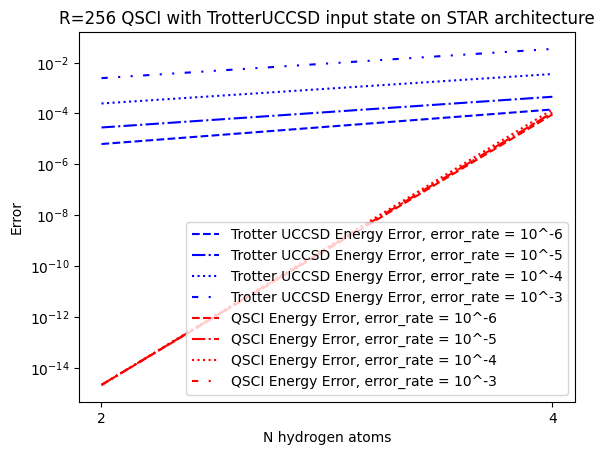

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes

ax: Axes = plt.axes()

linestyles = ("--", "-.", ":", (0, (3, 5, 1, 5, 1, 5)))

for trotter_uccsd_energy_err, s in zip(trotter_uccsd_energy_err_lists, linestyles):
    ax.semilogy(n_list, trotter_uccsd_energy_err, color= "blue", linestyle = s)
for qsci_energy_err, s in zip(qsci_energy_err_lists, linestyles):
    ax.semilogy(n_list, qsci_energy_err, color= "red", linestyle = s)

ax.legend(
    [
        "Trotter UCCSD Energy Error, error_rate = 10^-6",
        "Trotter UCCSD Energy Error, error_rate = 10^-5",
        "Trotter UCCSD Energy Error, error_rate = 10^-4",
        "Trotter UCCSD Energy Error, error_rate = 10^-3",
        "QSCI Energy Error, error_rate = 10^-6",
        "QSCI Energy Error, error_rate = 10^-5",
        "QSCI Energy Error, error_rate = 10^-4",
        "QSCI Energy Error, error_rate = 10^-3",
    ]
)
ax.set_xticks(n_list)
ax.set_title(f"R={BASIS_STATES} QSCI with TrotterUCCSD input state on STAR architecture")
ax.set_xlabel("N hydrogen atoms")
ax.set_ylabel("Error")

As seen above the QSCI energy error is consistently lower than the one obtained by TrotterUCCSD. This is because QSCI can obtain nearly exact results as long as a substantial amount of reference states are used. Even in the presence of a modest amount of noise, as long as the noise does not alter the set of preferred reference states that are obtained from sampling, the resulting diagonalization is unaffected. This is what makes QSCI a powerful technique.

Now let's also look at the resulting fidelity, this time including device dependent results that depend on noise.

In the below calculation we will set the 2-qubit gate error for the NISQ device as it is the main source of error. The value chosen is typical for a superconducting qubit device. For the STAR device, since the 2-qubit gates are implemented using the surface code, we base the error on the 1-qubit gates only which have in general lower error rates.

In [ ]:
from tqdm import tqdm


# We rewrite this function to skip the costly exact diagonalization
def get_hn_hamiltonian_uccsd(n):
    n_active_ele = n
    n_active_orb = n
    active_space = ActiveSpace(n_active_ele=n_active_ele, n_active_orb=n_active_orb)

    mole = gto.M(atom="H 0 0 0" + "".join([f"; H 0 0 {i}" for i in range(1, n)]))
    mf = scf.RHF(mole).run(verbose=0)
    hamiltonian, _ = get_qubit_mapped_hamiltonian(
        *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff, active_space)
    )

    ccsd = cc.CCSD(mf).run(verbose=0)

    uccsd = TrotterUCCSD(
        n_active_orb * 2,
        n_active_ele,
        trotter_number=TROTTER_STEPS,
        use_singles=USE_SINGLES,
        singlet_excitation=REDUCE_PARAMETER,
    )
    param = ccsd_param_to_circuit_param(uccsd, n_active_ele, ccsd.t1, ccsd.t2)
    hf_state = quantum_state(n_active_orb * 2, bits=2**n_active_ele - 1)
    state = apply_circuit(uccsd, hf_state)
    bound_state = state.bind_parameters(param)

    return ccsd, bound_state, hamiltonian


circuit_fidelity_nisq = []
circuit_fidelity_star_4 = []
circuit_fidelity_star_5 = []
circuit_fidelity_star_6 = []
n_list = [2, 4, 6]


for n in tqdm(n_list):
    ccsd, bound_state, hamiltonian = get_hn_hamiltonian_uccsd(n)

    fidelity_star = star_vms[0].analyze(bound_state.circuit).fidelity
    circuit_fidelity_star_6.append(fidelity_star)

    fidelity_star = star_vms[1].analyze(bound_state.circuit).fidelity
    circuit_fidelity_star_5.append(fidelity_star)

    fidelity_star = star_vms[2].analyze(bound_state.circuit).fidelity
    circuit_fidelity_star_4.append(fidelity_star)

    fidelity_nisq = nisq_vm.analyze(bound_state.circuit).fidelity
    circuit_fidelity_nisq.append(fidelity_nisq)

100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


Text(0, 0.5, 'Fidelity')

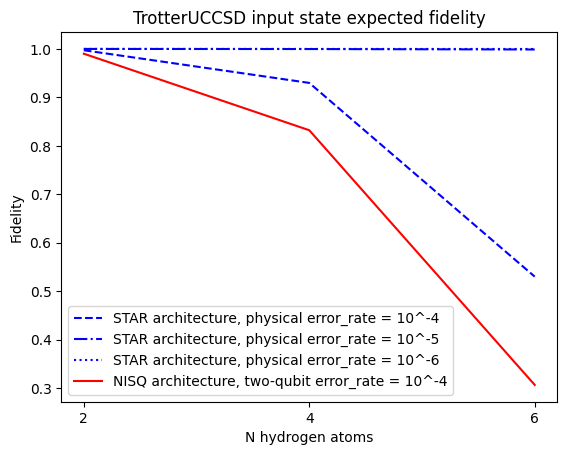

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes

ax: Axes = plt.axes()

ax.plot(n_list, circuit_fidelity_star_4, color= "blue", linestyle = "--")
ax.plot(n_list, circuit_fidelity_star_5, color= "blue", linestyle = "-.")
ax.plot(n_list, circuit_fidelity_star_6, color= "blue", linestyle = ":")
ax.plot(n_list, circuit_fidelity_nisq, color= "red")
ax.legend(
    [
        "STAR architecture, physical error_rate = 10^-4",
        "STAR architecture, physical error_rate = 10^-5",
        "STAR architecture, physical error_rate = 10^-6",
        "NISQ architecture, two-qubit error_rate = 10^-4",
    ]
)
ax.set_title("TrotterUCCSD input state expected fidelity")
ax.set_xlabel("N hydrogen atoms")
ax.set_xticks(n_list)
ax.set_ylabel("Fidelity")

## Summary

This notebook introduced QSCI based on the TrotterUCCSD ansatz. The learning outcomes included

- Simple molecular Hamiltonians and CC theory using PySCF
- TrotterUCCSD ansatz
- Using QSCI
- Transpiling and optimizing circuits
- Estimating fidelities of deep circuits with different architectures
- The performance of QSCI based on Trotter UCCSD
